In [5]:
# All Imports
import tensorflow as tf
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
from sklearn.model_selection import train_test_split


In [102]:
# Coincap aoi to get bitcoin data
endpoint = 'https://min-api.cryptocompare.com/data/v2/histoday'
response = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1999&api_key=346a5653477eed39d369f3b05523c27a427a45ab31125be8a8dbf06cf4478d49')
dataTable = pd.DataFrame(json.loads(response.content)['Data']['Data'])
dataTable = dataTable.set_index('time')
dataTable.index = pd.to_datetime(dataTable.index, unit='s')
target_col = 'close'

In [103]:
dataTable.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [104]:
# print first 5 
dataTable.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-04-13,426.58,421.41,424.74,38088.60,16183793.93,423.47
2016-04-14,425.44,421.84,423.47,30664.40,13038970.54,424.02
2016-04-15,429.49,423.25,424.02,54119.98,23214560.10,428.67
2016-04-16,432.00,426.84,428.67,29021.18,12517265.78,430.05
2016-04-17,430.62,423.79,430.05,25586.86,10980868.31,426.26


In [214]:
# print last 5
dataTable.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-09-29,42603.18,40790.67,41056.79,26354.27,1.100253e+09,41539.43
2021-09-30,44106.60,41436.79,41539.43,33984.98,1.469982e+09,43829.34
2021-10-01,48470.13,43304.82,43829.34,53577.95,2.498576e+09,48164.35
2021-10-02,48347.69,47468.49,48164.35,16062.18,7.690222e+08,47669.02
2021-10-03,48013.91,47137.07,47669.02,3868.25,1.839579e+08,47944.24


In [215]:
# training 60%, validation 20%, testing 20%
def data_split(dt, test_size=0.2, validation_size=0.25):
    remaining, test = train_test_split(dt, test_size=test_size, shuffle=False)
    train,validation  = train_test_split(remaining, test_size=validation_size, shuffle=False) # 0.25 x 0.8 = 0.2
    return train, validation, test

In [234]:
train, validation, test  = data_split(dataTable, test_size=0.2, validation_size=0.25)

                high       low      open  volumefrom      volumeto     close
time                                                                        
2020-08-30  11718.98  11470.07  11480.48    16398.78  1.906494e+08  11716.54
2020-08-31  11775.27  11586.36  11716.54    26331.03  3.079266e+08  11657.81
2020-09-01  12062.06  11540.42  11657.81    45202.86  5.372923e+08  11926.69
2020-09-02  11954.28  11219.19  11926.69    53717.87  6.181293e+08  11397.90
2020-09-03  11469.20  10017.43  11397.90    82662.97  8.947367e+08  10174.62
...              ...       ...       ...         ...           ...       ...
2021-09-29  42603.18  40790.67  41056.79    26354.27  1.100253e+09  41539.43
2021-09-30  44106.60  41436.79  41539.43    33984.98  1.469982e+09  43829.34
2021-10-01  48470.13  43304.82  43829.34    53577.95  2.498576e+09  48164.35
2021-10-02  48347.69  47468.49  48164.35    16062.18  7.690222e+08  47669.02
2021-10-03  48013.91  47137.07  47669.02     3868.25  1.839579e+08  47944.24

In [217]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

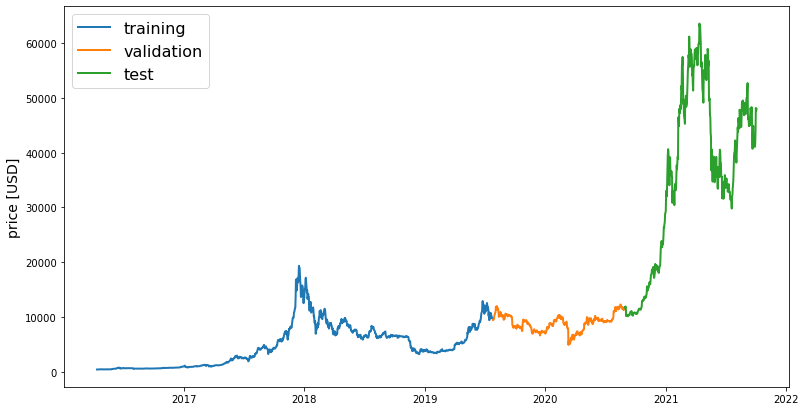

In [218]:
line_plot(train[target_col], validation[target_col], test[target_col], 'training', 'validation', 'test')

In [219]:
#normalizing the data
def normalise_zero_base(dt):
    return dt / dt.iloc[0] - 1

def normalise_min_max(dt):
    return (dt - dt.min()) / (dt.max() - dt.min())

In [293]:
def extract_window_data(dt, window_len=5, zero_base=True):
    window_data = []
#     print(dt.values)
    for idx in range(len(dt) - window_len):
        tmp = dt[idx: (idx + window_len)].copy()
#         if zero_base:
#             tmp = normalise_min_max(tmp) 
        print("idx",idx, tmp.values,tmp)

        window_data.append(tmp.values)
    return np.array(window_data)

In [294]:
def prepare_data(dt, target_col, window_len=10, zero_base=True, test_size=0.2, validation_size=0.25):
    
    train_d, validation_d, test_d = data_split(dt, test_size=test_size,validation_size=validation_size)
#     print(test_d)
    X_train = extract_window_data(train_d, window_len, zero_base)
    X_validation = extract_window_data(validation_d, window_len, zero_base)
    X_test = extract_window_data(test_d, window_len, zero_base)
#     print("X_test",X_test)
    y_train = train_d[target_col][window_len:].values
    y_validation = validation_d[target_col][window_len:].values
    y_test = test_d[target_col][window_len:].values
#     print("y_test",y_test)
    if zero_base:
        y_train = y_train / train_d[target_col][:-window_len].values - 1
        y_validation = y_validation / validation_d[target_col][:-window_len].values - 1
        y_test = y_test / test_d[target_col][:-window_len].values - 1

    return train_d, validation_d, test_d, X_train, X_validation, X_test, y_train, y_validation, y_test

In [295]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [296]:
np.random.seed(42)
window_len = 5
test_size = 0.2
validation_size=0.25
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [297]:
train_d, validation_d, test_d, X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_data(
    dataTable, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size, validation_size=validation_size)

range range(0, 1195)
range range(0, 395)
range range(0, 395)


In [225]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
38/38 [==============================] - 1s 22ms/step - loss: 0.1145 - val_loss: 0.0068
Epoch 2/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0920 - val_loss: 0.0066
Epoch 3/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0783 - val_loss: 0.0074
Epoch 4/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0628 - val_loss: 0.0068
Epoch 5/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0597 - val_loss: 0.0076
Epoch 6/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0532 - val_loss: 0.0076
Epoch 7/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.0066
Epoch 8/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0367 - val_loss: 0.0068
Epoch 9/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 0.0069
Epoch 10/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0268 - val_loss: 0.0069
Epoch 11/20
38/38 

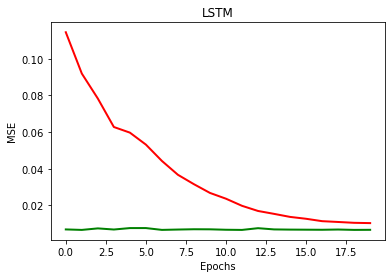

In [226]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [227]:
results = model.evaluate(X_test, y_test, batch_size=batch_size)
print("test loss, test acc:", results)

13/13 [==============================] - 0s 3ms/step - loss: 0.0085
test loss, test acc: 0.008472726680338383


In [233]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

[0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722
 0.01309722 0.01309722 0.01309722 0.01309722 0.01309722 0.0130

0.07127920690913432

In [229]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.008472725948987053

In [230]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

-0.009300022339212122

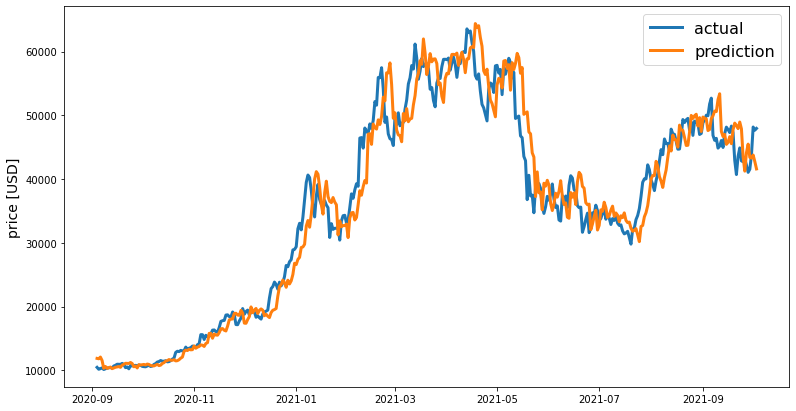

In [231]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(targets, label='actual', linewidth=3)
ax.plot(preds, label='prediction', linewidth=3)
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title("", fontsize=16)
ax.legend(loc='best', fontsize=16)
# line_plot(targets, preds, 'actual', 'prediction', lw=3)